In [91]:
!pip install catalyst

In [92]:
from torch.utils.data import Dataset
import pandas as pd
from pathlib import Path
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
from math import exp
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.data import DataLoader
from tqdm import tqdm

from catalyst.engines.torch import DeviceEngine

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

plt.rcParams.update({'font.size': 13})

In [93]:
batch_size = 16
sampling_method = "uniform" # Options: uniform, similarity
max_length = 50
_model = "recurrent" # Options: fixedconv, recurrent
task = "cleaning" # Options: cleaning, classification
device = 'cuda'

pretrained_path = "/pretrained/" + "cleaning_recurrent_uniform_50.pth"

In [94]:
if task == "cleaning":
  class_names = ["Reliable", "Unreliable"]
else:
  class_names = ["Healthy", "Sick"]

In [95]:
!pip install catalyst
from catalyst.dl import SupervisedRunner

runner = SupervisedRunner(engine=DeviceEngine(device= "cuda"))

# Test dataset and pretrained models

## Preprocessing, models and dataset classes

# New Section

In [96]:


def random_downsampling(l, k):
    if l < k:
        return np.asarray(list(range(l)))

    return np.asarray(sorted(random.sample(list(range(l)), k=k)))



def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)


def getmax_sim(sim):
    m = 0
    idx = None

    for k, x in sim.items():
        if m < x:
            m = x
            idx = k

    return k


# Downsampling function
def ssim_downsampling(sequence, k):
    '''
    Perform the downsampling using pytorch (and the GPU, it is really really faster !)
    :param sequence:
    :param k:
    :return:
    '''

    sequence = sequence.to('cuda')
    l = sequence.shape[0]
    keptindices = {i for i in range(l)}

    if l < k:
        return list(keptindices)

    s1 = sequence[:-1]
    s2 = sequence[1:]

    similarities = ssim(s1, s2, size_average=False).squeeze().cpu().detach().numpy()

    similarities = {(i, i + 1): similarities[i] for i in range(0, l - 1)}

    while len(keptindices) > k:
        key = getmax_sim(similarities)
        similarities.pop(key)

        nsim = float(ssim(sequence[key[0] - 1].unsqueeze(dim=0), sequence[key[1]].unsqueeze(dim=0),
                          size_average=False).squeeze().cpu().detach().numpy())
        similarities[(key[0] - 1, key[1])] = nsim

        keptindices.remove(key[0])

    return np.asarray(list(keptindices))


"""## Dataset class

This class embed the dataset, makes the preprocessing and load the requested data (cleaning or classification, our 2 tasks).
"""


class GlobulesDataset(Dataset):
    '''
    Load the data from file and provide an interface for the pytorch code.
    '''

    def __init__(self, path, task="cleaning", maxlength=20, preprocessing_method=None, unreliable_downsampling=5000):
        self.path = Path(path)
        self.preprocessing_method = preprocessing_method
        self.maxlength = maxlength
        self.task = task
        self.unreliable_downsampling = unreliable_downsampling

        df = pd.read_csv(self.path / "dataset.csv")
        self.y = df["label"].tolist()
        self._y = df["label"].tolist()
        self.sizes = df["size"].tolist()
        self.names = df["sequence_name"].tolist()

        self.len = len(self.y)

        # Base dataset has 3 labels: 0 "healthy" , 1 "sick/strange", 2 "unreliable"
        if self.task == "cleaning":
            # If cleaning we only have 2 labels: 1 if "unreliable", 0 if reliable
            self.y = np.array((np.array(self.y) == 2), dtype=int)
            if self.unreliable_downsampling:
                self.indices = list(np.argwhere(self.y != 1)[:, 0]) + random.sample(
                    list(np.argwhere(self.y == 1)[:, 0]), k=unreliable_downsampling)
                self.len = len(self.indices)
                print(self.len)

        elif self.task == "classification":
            # If classification we remove (true) unreliables
            # Thus we keep only elements which label is 0 or 1 (not 2)
            self.indices = [i for i, v in enumerate(self.y) if v != 2]
            self.len = len(self.indices)
            self.y = np.array(np.array(self.y) == 0, dtype=int)
        else:
            raise Exception("Bad argument")
        # Build a list of list, for each sequence gives a list of the element
        # we want to keep
        if preprocessing_method == "uniform":
            self.kept_elements = self.uniform_downsampling()
        elif preprocessing_method == "similarity":
            self.kept_elements = self.similarity_downsampling()
        else:
            pass

    def class_counts(self):
        if self.task == "classification":
            unique, counts = np.unique(self.y[self.indices], return_counts=True)
        else:
            if self.task == "cleaning" and self.unreliable_downsampling:
                unique, counts = np.unique(self.y[self.indices], return_counts=True)
            else:
                unique, counts = np.unique(self.y, return_counts=True)

        return counts

    def uniform_downsampling(self):
        keptelements = []
        for item in tqdm(range(self.len)):
            if self.task == "classification":
                item = self.indices[item]
            if self.task == "cleaning" and self.unreliable_downsampling:
                item = self.indices[item]

            if self.sizes[item] > self.maxlength:
                keptelements.append(random_downsampling(self.sizes[item], self.maxlength))
            else:
                keptelements.append([i for i in range(self.sizes[item])])

        return keptelements

    def similarity_downsampling(self):
        keptelements = []
        for item in tqdm(range(self.len)):
            if self.task == "classification":
                item = self.indices[item]
            if self.task == "cleaning" and self.unreliable_downsampling:
                item = self.indices[item]

            if self.sizes[item] > self.maxlength:
                im = np.array(Image.open(self.path / "img" / (self.names[item] + ".png")))
                im = torch.Tensor(im).view(31, 31, self.sizes[item]).permute(2, 0, 1)
                keptelements.append(ssim_downsampling(im.unsqueeze(dim=1), self.maxlength))
            else:
                keptelements.append([i for i in range(self.sizes[item])])

        return keptelements

    def __len__(self):
        return self.len

    def __getitem__(self, item):
        idx = item
        if self.task == "classification":
            idx = self.indices[item]
        if self.task == "cleaning" and self.unreliable_downsampling:
            idx = self.indices[item]

        im = np.array(Image.open(self.path / "img" / (self.names[idx] + ".png")))

        if self.preprocessing_method is not None:
            im = np.asarray([im[:, i * 31:(i + 1) * 31] for i in self.kept_elements[item]])

        else:
            im = np.asarray([im[:, i * 31:(i + 1) * 31] for i in range(self.sizes[idx])])

        return im / 255, self.y[idx]

    def get_class(self, item):
        idx = item
        if self.task == "classification":
            idx = self.indices[item]
        if self.task == "cleaning" and self.unreliable_downsampling:
            idx = self.indices[item]

        return self.y[idx]

    def get_seq(self, item, preprocessed=False):
        idx = item
        if self.task == "classification":
            idx = self.indices[item]
        if self.task == "cleaning" and self.unreliable_downsampling:
            idx = self.indices[item]

        im = np.array(Image.open(self.path / "img" / (self.names[idx] + ".png")))

        if self.preprocessing_method is not None:
            im = np.asarray([im[:, i * 31:(i + 1) * 31] for i in self.kept_elements[item]])
            l = int(min(self.sizes[idx], self.maxlength))

        else:
            im = np.asarray([im[:, i * 31:(i + 1) * 31] for i in range(self.sizes[idx])])
            l = min(self.sizes[idx])

        nim = np.zeros((31, 31 * l))
        for i in range(l):
            nim[:, i * 31:(i + 1) * 31] = im[i]

        return nim / 255, self.y[idx]


def fmax_length(x):
    l = 0

    for s in x:
        ltmp = len(s)
        if ltmp > l:
            l = ltmp
    return l


def pad_collate(batch, l=None):
    '''
    Pad a sequence of image with black images
    :param batch:
    :return:
    '''
    xx, yy = zip(*batch)

    if l is None or l < 0:
        l = fmax_length(xx)

    X = np.zeros((l, len(batch), 31, 31))

    for i, x in enumerate(xx):
        X[:len(x), i] = x

    yy = np.array(yy)

    return torch.Tensor(X), torch.Tensor(yy).long()



In [97]:

class RecurrentConvNet(nn.Module):
    """
    This implement an optimized version of the recurrent convolutionnal network in order to ease memory consuption.
    Instead of computing the feature map for each image and then feed all these features into the rnn we compute the feature map
    and then directly pass it to the recurrent network and then we compute the second feature map and so on.
    """

    def __init__(self, n_classes=3, device='cpu', softmax=True):
        '''

        :param n_classes: In our setup we can work on two problem: a classification in 3 classes (healthy, sick, garbage)
        but in some experiments we only try to classify ( (healthy, sick) and garbage) for further processing.
        :param device: cpu or cuda.
        '''
        super().__init__()

        self.softmax = softmax
        self.device = device
        self.hidden = 256

        # The convnet for feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3),
            nn.ReLU(),
        )

        self.rnnCell = nn.GRUCell(2304, self.hidden)

        # Two recurrent network to be able to keep informations in the long run for long sequences
        self.rnn = nn.GRU(self.hidden, self.hidden)

        # The simple classifier at the end of the processus
        self.classifier = nn.Sequential(nn.Linear(self.hidden, 64), nn.ReLU(), nn.Linear(64, n_classes))

    def forward(self, x):
        # We assume x = (seq_length, batch, 31, 31)
        x = torch.unsqueeze(x, dim=2)
        # x = (seq_length, batch, 1, 31, 31)

        batch_size = x.shape[1]
        seq_length = x.shape[0]

        hidden = torch.zeros((batch_size, self.hidden)).to(self.device)
        cell = torch.zeros((batch_size, self.hidden)).to(self.device)

        hiddens = [hidden]
        for i in range(seq_length):
            # Here we compute each feature map of the sequence independently.

            features = self.feature_extractor(x[i].float())
            # features = (batch, 64, h, w)

            features = torch.flatten(features, start_dim=1, end_dim=-1)

            hidden = self.rnnCell(features, hidden)
            hiddens.append(hidden)

        output, hidden = self.rnn(torch.stack(hiddens))

        output = self.classifier(output[-1])

        if self.softmax:
            return nn.functional.log_softmax(output, dim=1)
        else:
            return output


class FixedSizeConvnet(nn.Module):
    def __init__(self, in_channels, n_classes, softmax : bool = True, device='cpu'):

        super().__init__()

        self.softmax = softmax
        self.device = device
        self.in_channels = in_channels

        # The convnet for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels,8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(3),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(nn.Linear(1152, 32), nn.Tanh(), nn.Linear(32, n_classes))

    def forward(self, x):
        # We assume x = (seq_length, batch, 31, 31)
        x = torch.transpose(x, 0,1)
        # x = batch, seqlength, 31,31
        # seqlength = in_channel in that case

        features = torch.flatten(self.cnn(x), start_dim=1)
        # features = (batch, features_size)

        return self.classifier(features)

## Dataloading and evaluation

In [98]:
# Mouting data from drive 

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

data_path = "/content/drive/MyDrive/redbloodcellsicknesstest"

Mounted at /content/drive/


In [99]:
testset = GlobulesDataset(data_path + "/test", preprocessing_method=sampling_method, maxlength=max_length, task=task, unreliable_downsampling=False)
test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=lambda x: pad_collate(x, l=max_length), num_workers=4)

100%|██████████| 400/400 [00:00<00:00, 52293.16it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [100]:
from catalyst import utils

In [101]:
checkpoint = utils.load_checkpoint(path=data_path + pretrained_path)


if _model == "recurrent":
  model = RecurrentConvNet(n_classes=2, device=device, softmax=False).to(device)
else:
  model = FixedSizeConvnet(n_classes=2, device=device, softmax=False).to(device)


utils.unpack_checkpoint(
    checkpoint=checkpoint,
    model=model
)

In [102]:
y_probas = []


for pred in runner.predict_loader(loader=test_loader,
                                  model=model):
  y_probas.append(pred["logits"].cpu().detach().numpy())

y_probas = np.concatenate(y_probas)
y_pred = np.argmax(y_probas, axis=1)
y_true = testset.y

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [116]:
import pandas as pd

summary = dict()

summary["accuracy"] = accuracy_score(y_true, y_pred)
summary["precision"] = precision_score(y_true, y_pred, average=None)
summary["recall"] = recall_score(y_true, y_pred, average=None)

summary["f1"] = f1_score(y_true, y_pred, average=None)

print(summary["precision"][0])

pd.DataFrame(summary, index=class_names)

failsidx = np.argwhere((1-np.array(y_true)) * (np.array(y_pred) != y_true))
print(failsidx.shape)

print(sum(np.array(testset._y)[failsidx]))





0.9724770642201835
(94, 1)
[56]


In [104]:
%matplotlib inline

In [105]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=15)
    plt.yticks(tick_marks, classes, size=15)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization


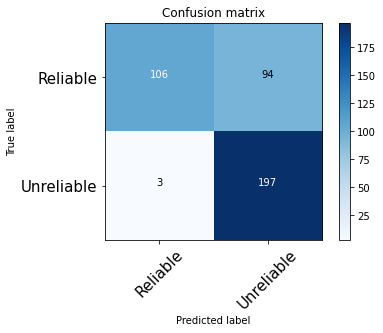

In [106]:
from sklearn.metrics import ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(conf_mat, display_labels=class_names, cmap=plt.cm.Blues)

plot_confusion_matrix(conf_mat, classes=class_names)




Normalized confusion matrix


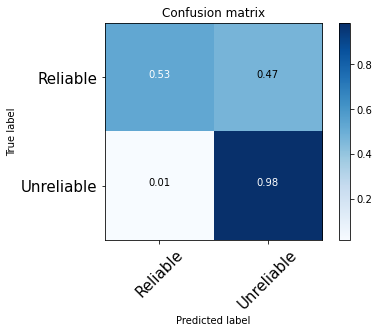

In [107]:
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True)

In [108]:
def plot_sequence_classification(sequences, pred_class, true_class, class_names=None, *args, **kwargs):
    if class_names:
        pred_class = [class_names[cls] for cls in pred_class]
        true_class = [class_names[cls] for cls in true_class]

    max_len = max(len(s) for s in sequences)
    N = len(sequences)
    fig, subplot = plt.subplots(ncols=2, nrows=N, dpi=120, gridspec_kw={'width_ratios': [6, 1]}) 
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.tight_layout()

    for k in range(N):
      seqlen = len(sequences[k])

      ax: plt.Axes = subplot[k][0]
      ax.imshow(sequences[k], cmap='gray', aspect="equal", interpolation="nearest")
      ax.axis('off')

      ax: plt.Axes = subplot[k][1]
      ax.axis('off')
      ax.text(0, 0.25, f"True class: {true_class[k]}\nPediction: {pred_class[k]}", fontsize=6)

    fig.tight_layout()

    return fig

#### Examples of fails

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  # Remove the CWD from sys.path while we load stuff.


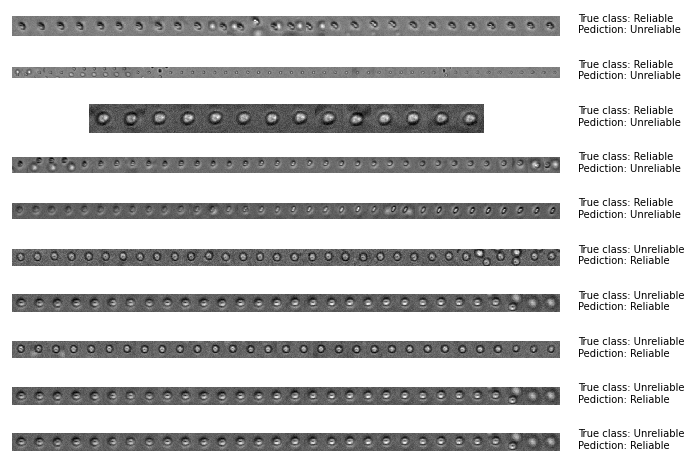

In [109]:
# Get id of element on which the model failed
fails = np.argwhere(y_pred!= y_true).reshape(-1)
true_classes = []
k=5

for i in range(2):

    indices = np.argwhere(testset.y == i).reshape(-1)
    
    indices = np.intersect1d(indices, fails)
    if len(indices) > 0:
        true_classes.append(np.random.choice(indices, k))


true_classes = np.asarray(true_classes, dtype=int).flatten()
fig = plot_sequence_classification([testset.get_seq(i, preprocessed=True)[0] for i in true_classes], y_pred[true_classes], testset.y[true_classes], class_names=class_names)

### Examples of success

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  # Remove the CWD from sys.path while we load stuff.


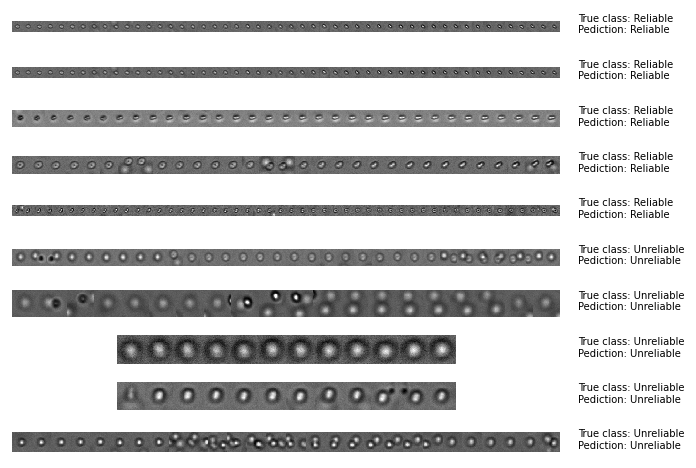

In [110]:
# Get id of element on which the model failed
successes = np.argwhere(y_pred == y_true).reshape(-1)
true_classes = []
k=5

for i in range(2):

    indices = np.argwhere(testset.y == i).reshape(-1)
    
    indices = np.intersect1d(indices, successes)
    if len(indices) > 0:
        true_classes.append(np.random.choice(indices, k))


true_classes = np.asarray(true_classes, dtype=int).flatten()
fig = plot_sequence_classification([testset.get_seq(i, preprocessed=True)[0] for i in true_classes], y_pred[true_classes], testset.y[true_classes], class_names=class_names)